## Necessary Imports

In [ ]:
import re

import pickle

import pandas as pd
import unicodedata
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_parquet('data.parquet', engine='pyarrow')
print(df.head())

                                                text  \
0  <s>[INST] Please translate "It happened after ...   
1  <s>[INST] Please translate "it happened on the...   
2  <s>[INST] Please translate "David said to him,...   
3  <s>[INST] Please translate "David said to him,...   
4  <s>[INST] Please translate "David said to the ...   

                                                  en  \
0  It happened after the death of Saul, when Davi...   
1  it happened on the third day, that behold, a m...   
2  David said to him, "Where do you come from?" H...   
3  David said to him, "How did it go? Please tell...   
4  David said to the young man who told him, "How...   

                                                  np  
0  दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...  
1  तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...  
2  दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ...  
3  दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “...  
4  दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395611 entries, 0 to 395610
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    395611 non-null  object
 1   en      395611 non-null  object
 2   np      395611 non-null  object
dtypes: object(3)
memory usage: 9.1+ MB


## Selecting only 10,000 rows from the dataset

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df = df.head(10000)

In [ ]:
# df.to_csv('data.csv', index = False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   en      10000 non-null  object
 2   np      10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


### Exporting the english and nepali columns into respective text files so as to train and save the respective tokenizers

In [ ]:
nepali_text = df['np']
english_text = df['en']

In [ ]:
nepali_text.head()

,np
0,दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [ ]:
english_text.head()

,en
0,"It happened after the death of Saul, when Davi..."
1,"it happened on the third day, that behold, a m..."
2,"David said to him, ""Where do you come from?"" H..."
3,"David said to him, ""How did it go? Please tell..."
4,"David said to the young man who told him, ""How..."


In [ ]:
# nepali_text.to_csv('nepali_data.txt', index = False)
# english_text.to_csv('english_data.txt', index = False)

In [ ]:
# from google.colab import files
# files.download('nepali_data.txt')
# files.download('english_data.txt')

## Data Pre-processing

- padding for the encoder's input
- sos and eos for the decoder's input

In [ ]:
df.head()

,text,en,np
0,"<s>[INST] Please translate ""It happened after ...","It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,"<s>[INST] Please translate ""it happened on the...","it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"<s>[INST] Please translate ""David said to him,...","David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"<s>[INST] Please translate ""David said to him,...","David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"<s>[INST] Please translate ""David said to the ...","David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [ ]:
df = df.drop(columns = ['text'])

In [ ]:
df.head()

,en,np
0,"It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,"it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [ ]:
text = 'पर्व'
print(text.encode('utf-8'))
text = unicodedata.normalize("NFD", text)
print(text.encode('utf-8'))

b'\xe0\xa4\xaa\xe0\xa4\xb0\xe0\xa5\x8d\xe0\xa4\xb5'
b'\xe0\xa4\xaa\xe0\xa4\xb0\xe0\xa5\x8d\xe0\xa4\xb5'


In [ ]:
def clean_text(text, lang):
  text.strip()

  if lang == 'en':
    text = text.lower()
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-z!?]+", r" ", text)

  text = unicodedata.normalize("NFC", text)
  text = re.sub(r"\s+", " ", text)
  return text

In [ ]:
df['en'] = df['en'].apply(clean_text, lang='en')
df['np'] = df['np'].apply(clean_text, lang = 'np')

In [ ]:
df.head()

,en,np
0,it happened after the death of saul when david...,दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,it happened on the third day that behold a man...,तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,david said to him where do you come from ? he ...,"दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,david said to him how did it go ? please tell ...,"दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,david said to the young man who told him how d...,"दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [ ]:
df["nep_in"]  = df["np"].map(lambda s: "<sos> " + s)
df["nep_out"] = df["np"].map(lambda s: s + " <eos>")

In [ ]:
df.head()

,en,np,nep_in,nep_out
0,it happened after the death of saul when david...,दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...,<sos> दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए।...,दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,it happened on the third day that behold a man...,तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...,<sos> तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा ...,तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,david said to him where do you come from ? he ...,"दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ...","<sos> दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?”...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,david said to him how did it go ? please tell ...,"दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “...","<sos> दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,david said to the young man who told him how d...,"दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ...","<sos> दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी ज...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


#### Tokenizers

In [ ]:
class BPETokenizer:
  def __init__(self):
    self.vocab = {0:'<pad>', 1:'<sos>', 2:'<eos>'}
    self.inverse_vocab = {'<pad>':0, '<sos>':1, '<eos>':2}
    self.merges = {}

  def train(self, text, vocab_size):
    unique_chars = []

    unique_chars = [chr(i) for i in range(3,259)]
    text_chars = set(text)

    unique_chars.extend(char for char in sorted(text_chars) if char not in unique_chars)

    self.vocab = {i:char for i, char in enumerate(unique_chars, start = 3)}
    self.inverse_vocab = {char:i for i, char in enumerate(unique_chars, start = 3)}

    sequence = [self.inverse_vocab[char] for char in text]

    while len(self.vocab) < vocab_size:
      pair_counts = Counter(zip(sequence,sequence[1:]))

      if not pair_counts:
        break

      best_pair = max(pair_counts.items(), key = lambda x: x[1])[0]

      new_token_id = max(self.vocab.keys()) + 1

      self.merges[best_pair] = new_token_id

      merge_symbol = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]

      self.vocab[new_token_id] = merge_symbol
      self.inverse_vocab[merge_symbol] = new_token_id


      new_seq = []
      i = 0
      while i < len(sequence):
          if i < len(sequence)-1 and (sequence[i], sequence[i+1]) == best_pair:
              new_seq.append(new_token_id)
              i += 2
          else:
              new_seq.append(sequence[i])
              i += 1
      sequence = new_seq

  def encode(self,text):
    tokens = [self.inverse_vocab[ch] for ch in text]
    for pair, new_id in self.merges.items():
        new_tokens, i = [], 0
        while i < len(tokens):
            if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == pair:
                new_tokens.append(new_id)
                i += 2
            else:
                new_tokens.append(tokens[i])
                i += 1
        tokens = new_tokens
    return tokens


  def decode(self,tokens):
    return ''.join(self.vocab[token] for token in tokens)

In [ ]:
class CharacterTokenizer:
    def __init__(self):
        self.vocab = {
            0: '<pad>', 1: '<sos>', 2: '<eos>'
        }
        self.inverse_vocab = {
            '<pad>': 0, '<sos>': 1, '<eos>': 2
        }

    def train(self, text):
        next_id = 3
        chars = sorted(set(text))

        for ch in chars:
            if ch in self.inverse_vocab:
                continue
            self.vocab[next_id] = ch
            self.inverse_vocab[ch] = next_id
            next_id += 1

    def encode(self, text):
        tokens = []

        has_sos = '<sos>' in text
        has_eos = '<eos>' in text

        if has_sos:
            text = text.replace('<sos>', '')
        if has_eos:
            text = text.replace('<eos>', '')

        for ch in text:
            tokens.append(self.inverse_vocab.get(ch, 0))

        if has_sos:
            tokens.insert(0, 1)
        if has_eos:
            tokens.append(2)
        return tokens

    def decode(self, tokens):
        chars = []
        for idx in tokens:
            if idx == 0:
                continue
            chars.append(self.vocab.get(idx, ''))
        return ''.join(chars)

In [ ]:
with open('nepali_tokenizer.pkl', 'rb') as nep:
    nep_tokenizer = pickle.load(nep)

with open('english_tokenizer.pkl', 'rb') as eng:
    eng_tokenizer = pickle.load(eng)

Need to define these within the tokenizers or they'll take the space of somebody else

### Encoding

In [ ]:
eng_tokenized = df["en"].apply(eng_tokenizer.encode)
nep_in_tokenized  = df["nep_in"].apply(nep_tokenizer.encode)
nep_out_tokenized = df["nep_out"].apply(nep_tokenizer.encode)

In [ ]:
print(len(eng_tokenizer.vocab))
print(len(nep_tokenizer.vocab))

5000
90


In [ ]:
sample = df['en'][1]
print(len(sample.split()))

44


In [ ]:
max_len = 50

eng_padded    = pad_sequences(eng_tokenized,    maxlen=max_len, padding="post", value=0)
nep_in_padded = pad_sequences(nep_in_tokenized,  maxlen=max_len, padding="post", value=0)
nep_out_padded= pad_sequences(nep_out_tokenized, maxlen=max_len, padding="post", value=0)

In [ ]:
dec_inputs = nep_in_padded
dec_outputs = nep_out_padded

In [ ]:
print(dec_inputs[1])
print(dec_outputs[1])

[81  4 29 43 74  4 58 81 60 83 50 81  4 60 66 79 66  4 33 59 67 73 32  4
 71 64 83 64 73 59  4 42 66 83 59  4 57 54 83 52 68 55 83  4 42 66 83 65
 81 84]
[29 43 74  4 58 81 60 83 50 81  4 60 66 79 66  4 33 59 67 73 32  4 71 64
 83 64 73 59  4 42 66 83 59  4 57 54 83 52 68 55 83  4 42 66 83 65 81 84
  4  2]


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, encoder_inputs, decoder_inputs, decoder_outputs):
        self.encoder_inputs = torch.tensor(encoder_inputs, dtype=torch.long)
        self.decoder_inputs = torch.tensor(decoder_inputs, dtype=torch.long)
        self.decoder_outputs = torch.tensor(decoder_outputs, dtype=torch.long)

    def __len__(self):
        return len(self.encoder_inputs)

    def __getitem__(self, idx):
        return {
            "encoder_inputs": self.encoder_inputs[idx],
            "decoder_inputs": self.decoder_inputs[idx],
        }, self.decoder_outputs[idx]

In [ ]:
full_dataset = TranslationDataset(eng_padded, dec_inputs, dec_outputs)

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

## Architecture

In [ ]:
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_rate):
    super(Encoder,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_rate)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size,num_layers, dropout = dropout_rate)

  def forward(self,x):
    # x [s,B]
    embedding = self.dropout(self.embedding(x)) # [s,B,emb]
    outputs, (hidden, cell) = self.lstm(embedding)
    # outputs [s,B,h]
    # hidden  [n_layers, B, h]
    # cell    [n_layers, B, h]
    return hidden, cell

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout_rate):
    super(Decoder,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_rate)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = dropout_rate)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden, cell):
    # x [B]
    x = x.unsqueeze(0) # [1,B]

    embedding = self.dropout(self.embedding(x)) # [1, B, emb]
    outputs, (hidden, cell) = self.lstm(embedding, (hidden, cell))
    # outputs  [1,B,h]
    # hidden   [n_layers, B, h]
    # cell     [n_layers, B, h]
    predictions = self.fc(outputs)  # [1,B,out]

    predictions = predictions.squeeze(0) # [B, out]

    return predictions, hidden, cell

In [ ]:
class Translator(nn.Module):
  def __init__(self,encoder,decoder):
    super(Translator,self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,source,target,ratio = 0.6):
    # [s, B]
    source = source['encoder_inputs']

    N = source.shape[1] # B
    target_len = target.shape[0] # s

    target_vocab_size = len(nep_tokenizer.vocab)

    hidden, cell = self.encoder(source)
    x = target[0]
    outputs = torch.zeros(target_len, N, target_vocab_size).to(device)

    for t in range(1, target_len):
      output, hidden, cell = self.decoder(x, hidden, cell)
      outputs[t] = output
      x = target[t]

    return outputs

In [ ]:
num_epochs = 50

encoder = Encoder(input_size = len(eng_tokenizer.vocab),
                  embedding_size = 50,
                  hidden_size = 264,
                  num_layers = 2,
                  dropout_rate = 0.5).to(device)

decoder = Decoder(input_size = len(nep_tokenizer.vocab),
                  embedding_size = 50,
                  hidden_size = 264,
                  output_size = len(nep_tokenizer.vocab),
                  num_layers = 2,
                  dropout_rate = 0.5).to(device)


model = Translator(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index = 0)

In [ ]:
loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        encoder_inputs = inputs['encoder_inputs'].to(device)
        decoder_inputs = inputs['decoder_inputs'].to(device)
        targets = targets.to(device)

        encoder_inputs = torch.clamp(encoder_inputs, 0, len(eng_tokenizer.vocab) - 1)

        # Forward pass
        outputs = model(
            {"encoder_inputs": encoder_inputs},
            decoder_inputs,
            ratio=0.6
        )  #  [s, B, vocab_size]

        # Reshape for loss
        outputs = outputs[1:].reshape(-1, outputs.shape[-1])
        targets = targets[1:].reshape(-1)

        loss = loss_fn(outputs, targets)
        loss_list.append(loss.item())
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

Epoch [1/50], Loss: 3.3757
Epoch [2/50], Loss: 3.2708
Epoch [3/50], Loss: 3.2563
Epoch [4/50], Loss: 3.2463
Epoch [5/50], Loss: 3.2372
Epoch [6/50], Loss: 3.2351
Epoch [7/50], Loss: 3.2294
Epoch [8/50], Loss: 3.2266
Epoch [9/50], Loss: 3.2261
Epoch [10/50], Loss: 3.2235
Epoch [11/50], Loss: 3.2199
Epoch [12/50], Loss: 3.2226
Epoch [13/50], Loss: 3.2214
Epoch [14/50], Loss: 3.2193
Epoch [15/50], Loss: 3.2205
Epoch [16/50], Loss: 3.2182
Epoch [17/50], Loss: 3.2205
Epoch [18/50], Loss: 3.2186
Epoch [19/50], Loss: 3.2198
Epoch [20/50], Loss: 3.2185
Epoch [21/50], Loss: 3.2175
Epoch [22/50], Loss: 3.2183
Epoch [23/50], Loss: 3.2166
Epoch [24/50], Loss: 3.2172
Epoch [25/50], Loss: 3.2139
Epoch [26/50], Loss: 3.2147
Epoch [27/50], Loss: 3.2143
Epoch [28/50], Loss: 3.2154


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
from google.colab import files
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

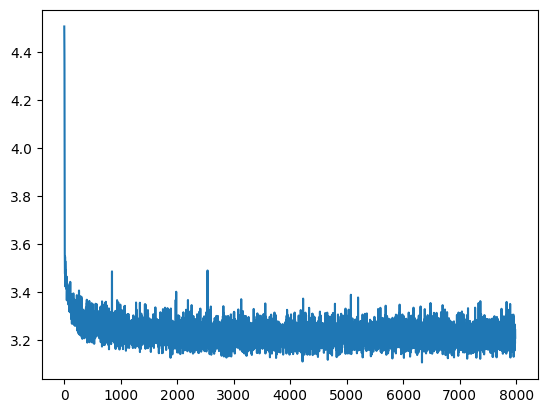

In [ ]:
plt.plot(loss_list)

In [ ]:
def translate_sentence(model, sentence, eng_tokenizer, nep_tokenizer, max_len=50, device='cpu'):
    model.eval()

    tokens = eng_tokenizer.encode(sentence.lower())
    tokens = [1] + tokens + [2]
    input_ids = tokens

    encoder_input = torch.tensor(input_ids, dtype=torch.long).unsqueeze(1).to(device)

    encoder_input = torch.clamp(encoder_input, 0, len(eng_tokenizer.vocab) - 1)

    with torch.no_grad():
        hidden, cell = model.encoder(encoder_input)

    outputs = []
    x = torch.tensor([1], dtype=torch.long).to(device)

    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, cell = model.decoder(x, hidden, cell)
            prediction = output.argmax(1)

        pred_token = prediction.item()
        if pred_token == nep_tokenizer.vocab[2]:
            break

        outputs.append(pred_token)
        x = prediction

    print(outputs)
    translated_sentence = nep_tokenizer.decode(outputs)
    return translated_sentence

In [ ]:
english_sentence = "hello nice to meet you"
translated = translate_sentence(model, english_sentence, eng_tokenizer, nep_tokenizer, device=device)
print("Nepali Translation:", translated)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Nepali Translation:                                                   
